# 2. Interpolation

```{admonition} Additional resource
:class: warning 
Shen, Z., & Serkh, K. (2022). [On polynomial interpolation in the monomial basis](https://arXiv.org/abs/2212.10519)
```

You have a function $f$ defined on the interval $[a, b]$, but only have access to $n + 1$ evaluations of the function at unique nodes $\{x_0, x_1, x_2, \ldots, x_n\} := \{x_i\}_{i=0}^n$, where the function takes values $\{ y_0, y_1, y_2, \ldots, y_n \} := \{y_i\}_{i=0}^n$. How do you evaluate the function at some new point $x^{\ast}$?

We start with the oldest trick in the book: 

## 2.1. The Vandermonde trick

Try fitting an degree-$n$ polynomial through the points,
$$ p(x) = \sum_{k = 0}^{n}a_k x^k, $$
so that the function evaluations become constraints

\begin{align}
p(x_0) &= a_0 + a_1 x_0 + a_2 x_0^2 + \ldots + a_n x_0^n = y_0,\\
p(x_1) &= a_0 + a_1 x_1 + a_2 x_1^2 + \ldots + a_n x_1^n = y_1,\\
\vdots &\vphantom{=}\\
p(x_n) &= a_0 + a_1 x_n + a_2 x_n^2 + \ldots + a_n x_n^n = y_n.
\end{align}

This can be rewritten rather compactly as

\begin{equation}
\begin{bmatrix}
1 & x_0 & x_0^2 & \ldots & x_0^n \\
1 & x_1 & x_1^2 & \ldots & x_1^n \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_n & x_n^2 & \ldots & x_n^n 
\end{bmatrix}
\begin{bmatrix}
a_0 \\ a_1 \\ \vdots \\ a_n 
\end{bmatrix}
= 
\begin{bmatrix}
y_0 \\ y_1 \\ \vdots \\ y_n 
\end{bmatrix},
\end{equation}

or simply $Ma = y$, where we collected the unknown coefficients into the vector $a$, the function evaluations into $y$, and $M(\{x^{\ast}_i\}_{i=0}^n)$ is called the **Vandermonde matrix**.

To evaluate $f$ at a new set of points $\{x^{\ast}_i\}_{i=0}^m$, we can simply solve $Ma = y$ with a backwards-stable algorithm to get $a$, and then left-multiply it by a _new_ Vandermonde matrix $N(\{x^{\ast}_i\}_{i=0}^m)$ (filled with the $\{x^{\ast}_i\}_{i=0}^m$.

```{admonition} Algorithm
:class: hint
A backwards-stable and efficient way to interpolate using the Vandermonde trick is to build an $(m+1) \times (n+1) $ interpolation matrix $L = NM^{-1}$ using the (scaled and centered) source $\{x_i\}_{i=0}^n$ and target $\{x^{\ast}_i\}_{i=0}^m$ nodes:

1. Fill up the $M$ and $N$ matrices column-by-column, using element-wise multiplication of entries with those of the previous column,
2. Compute $L$ as $L = (\text{solve}(M^{T}, N^T))^T$, or in MATLAB notation: `L = (M'\N')'`.

See, for example [this implementation](https://github.com/ahbarnett/BIE3D/blob/master/utils/interpmat_1d.m) of Helsing's algorithm by Alex Barnett.
```

```{admonition} Question
How can doing interpolation like this go wrong? (Hint: think back to the example at the end of the previous lecture.)
```

Intuitively, one might worry that if the magnitude of the (exact) coefficients $||a||$ gets large, we'll run into the same poorly conditioned problem as we did when evaluating the _expanded_ $(x-2)^9$ from the last lecture. This is a valid concern.

However, the frequently used warning of 
> avoid using Vandermonde matrices for interpolation because their condition number gets large (exponentially) quickly

is misleading, and unnecessarily restricts the use of this method. 

```{admonition} Theorem
:class: hint
The monomial/Vandermonde basis is generally as good as a well-conditioned polynomial basis for interpolation, provided that 
$$\kappa < 1/\mu_M.$$
```

To investigate when it _really_ is inappropriate to use Vandermonde matrices, we'll need to distinguish between two different sources of error: the choice of interpolating polynomial, and the choice of basis it is represented in.

## 2.2 Choice of nodes and choice of basis

```{admonition} Question
Assume that you are given the function $f$ and nothing else. What parameters are you free to pick when interpolating it?
```

If we aren't given the **interpolation/collocation nodes** $\{x_i\}_{i=0}^n$, then they are parameters of the interpolation problem. 
Once they are chosen, they determine the **interpolating polynomial/interpolant** uniquely.

But we are also free to choose the **basis** in which the interpolating polynomial is represented. In the Vandermonde case, that basis is the **monomial** one: $1, x, x^2, \ldots, x^n$. This then determines the polynomial coefficients (the $\{a_i\}_{i=0}^n$ in the Vandermonde system). Other choices include
- the Lagrange basis, $$ l_k(x) := \prod_{j = 0, j \neq k}^n \frac{x - x_j}{x_k - x_j} \quad  \text{for } k = 0, 1, \ldots n,$$
- Chebyshev polynomials,
- Legendre polynomials,
- Newton polynomials.


```{admonition} Proposition
:class: hint
The nodes $\{x_i\}_{i=0}^n$ determine the interpolant uniquely as:
$$ p(x) = \sum_{k = 0}^n y_k l_k(x), $$
since 
$$ l_k(x_i) = \begin{cases} \prod_{j \neq k} \frac{x_k - x_j}{x_k - xj} = 1 \quad &\text{if } i = k, \\
0 \quad &\text{if } i \neq k, \end{cases}
$$
so $p(x_i) = \sum y_k \delta_{ki} = y_i$ $\forall i$ is a solution and is unique.
```

It is [true](https://link.springer.com/article/10.1007/PL00005392) that the condition number of the Vandermonde matrix $M$ gets exponentially large with $n$ for any set of real collocation nodes $\{x_i\}_{i=0}^n$. We can check that with a little script: 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

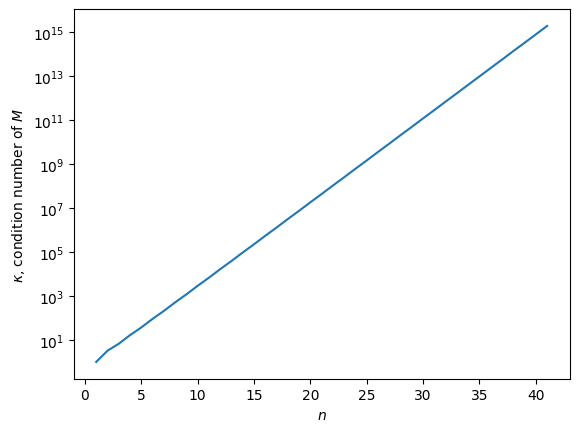

In [17]:
def vdm(x):
    """ 
    Computes the Vandermonde matrix from the input collocation nodes x.
    """
    n = x.shape[0]
    M = np.ones((n, n))
    for i in range (1, n):
        M[:, i] = M[:, i-1]*x
    return M

# Compute n+1 Chebyshev polynomial roots
chebx = lambda n: np.cos(np.linspace(0, np.pi, n+1))

n = np.arange(1, 42, dtype = int)
cond = np.array([np.linalg.cond(vdm(chebx(m))) for m in n])

plt.figure()
plt.semilogy(n, cond)
plt.xlabel("$n$")
plt.ylabel("$\kappa$, condition number of $M$")
plt.show()

This suggests that even at the modest $n = 10$, $\kappa \approx 10^3$. But let's see if we lose accuracy already at that point:

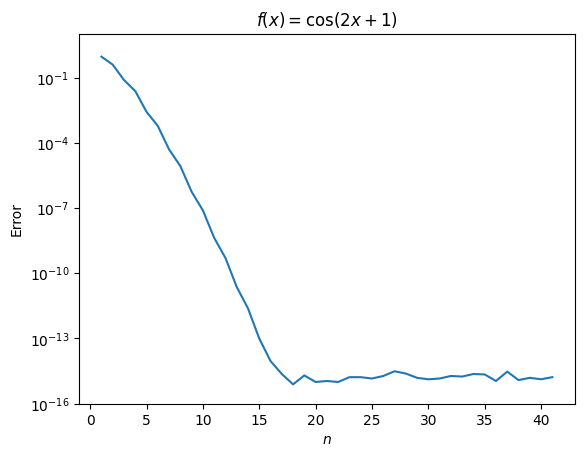

In [31]:
def interpvdm(f, x, x_star):
    """ Given a function f, collocation nodes x, and target nodes x_star,\
    computes interpolation matrix using the monomial basis and returns\
    f interpolated at x_star.
    """
    r = x.shape[0]
    q = x_star.shape[0]
    V = np.ones((r, r))
    R = np.ones((q, r))
    for j in range(1, r):
        V[:, j] = V[:, j-1]*x
        R[:, j] = R[:, j-1]*x_star
    N = np.linalg.solve(V.T, R.T).T
    f_star = np.dot(N, f(x))
    return f_star

f = lambda x: np.cos(2*x + 1)
x_star = np.linspace(-1, 1, 100)
err = np.array([np.max(np.abs(f(x_star) - interpvdm(f, chebx(m), x_star))) for m in n])

plt.figure()
plt.semilogy(n, err)
plt.title("$f(x) = \cos(2x + 1)$");plt.xlabel("$n$");plt.ylabel("Error");plt.ylim((1e-16,10))
plt.show()

What?! Interpolation in the monomial basis seems to work just fine beyond $n = 10$, and its accuracy quickly reaches $\mu_M$. 
Now try some other functions that require higher-order interpolation either because they cross zero many times, due to a nearby singularity, or because they are non-smooth: 

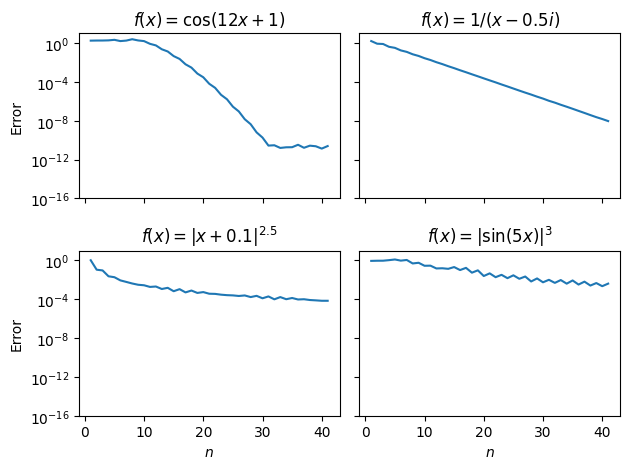

In [34]:
f = lambda x: np.cos(12*x + 1)
err1 = np.array([np.max(np.abs(f(x_star) - interpvdm(f, chebx(m), x_star))) for m in n])

f = lambda x: 1/(x - 0.5*1j)
err2 = np.array([np.max(np.abs(f(x_star) - interpvdm(f, chebx(m), x_star))) for m in n])

f = lambda x: np.abs(x + 0.1)**2.5
err3 = np.array([np.max(np.abs(f(x_star) - interpvdm(f, chebx(m), x_star))) for m in n])

f = lambda x: np.abs(np.sin(5*x))**3
err4 = np.array([np.max(np.abs(f(x_star) - interpvdm(f, chebx(m), x_star))) for m in n])

fig, ax = plt.subplots(2, 2, sharex = True, sharey = True)
plt.ylim((1e-16,1e1))
ax[0,0].semilogy(n, err1);ax[0,1].semilogy(n, err2);ax[1,0].semilogy(n, err3);ax[1,1].semilogy(n, err4)
ax[1,0].set_xlabel("$n$");ax[1,1].set_xlabel("$n$")
ax[0,0].set_ylabel("Error");ax[1,0].set_ylabel("Error")
ax[0,0].set_title("$f(x) = \cos(12x + 1)$");ax[0,1].set_title("$f(x) = 1/(x - 0.5i)$");ax[1,0].set_title("$f(x) = |x + 0.1|^{2.5}$");ax[1,1].set_title("$f(x) = |\sin(5x)|^3$")
plt.tight_layout();plt.show()

Here, we observe different (slower) _convergence rates_, but it's not clear whether slower convergence is due to the large condition number of $M$, or something else. Keeping the same collocation nodes, let us compare interpolation of the above functions using a different basis: the Lagrange basis. Evaluation of the interpolating polynomial $p$, unlike in the monomial basis, does not have a large $\kappa$. But first, some things to note:

```{admonition} Aside
**Convergence rates**. When we talk about "rate of convergence", we mean the rate at which error in a given algorithm decreases with computational effort (e.g. number of collocation nodes, $n$). These rates have different names that are summarized below.

|    Rate   |   Name   |
| :-------- | -------: |
| $cn^{-1}$ | first-order/algebraic |
| $cn^{-p}$ | $p$th order |
| $c_1a^{-c_2 n} = c_3e^{-c_4 n}$ | geometric/exponential |
| $c_1e^{-c_2 n^2}$ | quadratic |
| $c_1e^{-c_2 n^r}$, $r \geq 1$ | spectral |
```

```{admonition} Aside
**Optimal choice of collocation nodes**. The choice of having $\{x_i\}_{i=0}^n$ be the roots of Chebyshev polynomials is not a coincidence. These roots are projections of a half complex unit circle divided into $n$ equal arcs onto the real axis, including the endpoints $\pm 1$. It turns out that they are the _optimal_ choice for approximating smooth functions $f$, meaning that the interpolation error (assuming interpolation is done _exactly_) is minimal.
```

Interpolation in the Lagrange basis can be done in a backwards stable way via **barycentric interpolation**. We call a `scipy` routine that performs it:

In [36]:
import scipy.interpolate as sciint

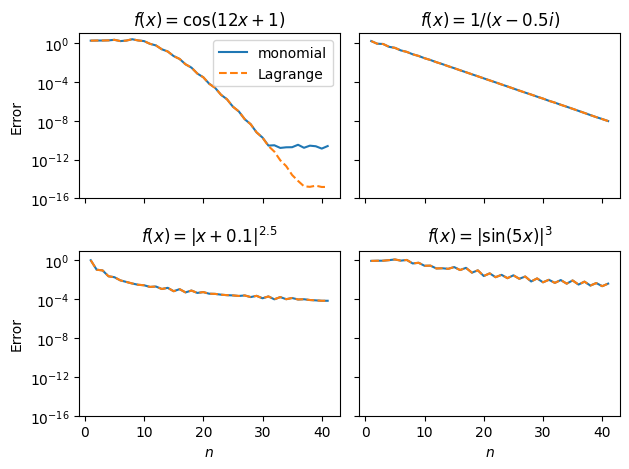

In [43]:
baryint = lambda n, f: sciint.barycentric_interpolate(chebx(n), f(chebx(n)), x_star)

f = lambda x: np.cos(12*x + 1)
err1b = np.array([np.max(np.abs(f(x_star) - baryint(m, f))) for m in n])

f = lambda x: 1/(x - 0.5*1j)
err2b = np.array([np.max(np.abs(f(x_star) - baryint(m, f))) for m in n])

f = lambda x: np.abs(x + 0.1)**2.5
err3b = np.array([np.max(np.abs(f(x_star) - baryint(m, f))) for m in n])

f = lambda x: np.abs(np.sin(5*x))**3
err4b = np.array([np.max(np.abs(f(x_star) - baryint(m, f))) for m in n])

fig, ax = plt.subplots(2, 2, sharex = True, sharey = True)
plt.ylim((1e-16,1e1))
ax[0,0].semilogy(n, err1, label = "monomial");ax[0,1].semilogy(n, err2);ax[1,0].semilogy(n, err3);ax[1,1].semilogy(n, err4)
ax[0,0].semilogy(n, err1b, '--', label = "Lagrange");ax[0,1].semilogy(n, err2b, '--');ax[1,0].semilogy(n, err3b, '--');ax[1,1].semilogy(n, err4b, '--')
ax[1,0].set_xlabel("$n$");ax[1,1].set_xlabel("$n$");ax[0,0].set_ylabel("Error");ax[1,0].set_ylabel("Error")
ax[0,0].set_title("$f(x) = \cos(12x + 1)$");ax[0,1].set_title("$f(x) = 1/(x - 0.5i)$");ax[1,0].set_title("$f(x) = |x + 0.1|^{2.5}$");ax[1,1].set_title("$f(x) = |\sin(5x)|^3$")
ax[0,0].legend()
plt.tight_layout();plt.show()